In [1]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [16]:
def plot_1D(X):
    K, _, T = X.shape
    cmap = plt.cm.viridis  
    fig, ax = plt.subplots() 

    for k in range(K):
        for t in range(T - 1):
            ax.plot([t, t + 1], [X[k, 0, t], X[k, 0, t + 1]], color=cmap(t / (T - 1)))

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
def get_rotation_params(K, T, key):
    time = jnp.linspace(0, 2 *jnp.pi, T)[:, jnp.newaxis] #4
    radii = jnp.linspace(0.1, 2, K)
    radii = random.permutation(key, radii)
    phases = jnp.linspace(0, 2*jnp.pi, K)
    return time, radii, phases

def get_rotations(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    sine_waves = jnp.sin(time + phases) * radii
    cosine_waves = jnp.cos(time + phases) * radii
    X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)  
    return X

def get_infty_traj(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    r = radii * jnp.cos(time + phases)
    theta = radii * jnp.sin(time + phases)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X = jnp.stack([x.T, y.T], axis=1)
    return X

def get_expansions(K, T, key, oneD=False):
    if oneD == False:
        initial_rates = 0.05 * (random.uniform(key, shape=(K, 2, 1)) - 0.5)
    else:
        initial_rates = 0.1 * (random.uniform(key, shape=(K, 1, 1)) - 0.5)
    time_steps = jnp.arange(T)
    X = jnp.exp(initial_rates * time_steps)
    return X

def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]

def get_oscillator(K, T, seed = 42):
    np.random.seed(seed) 
    initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(K, 2))

    t_span = (0, 10)   
    t_eval = np.linspace(t_span[0], t_span[1], T)  
    X = np.zeros((K, 2, T))
    for i, initial_conditions in enumerate(initial_conditions_list):
        solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
        x1 = solution.y[0]
        x2 = solution.y[1]

        X[i, 0, :] = x1
        X[i, 1, :] = x2
    X = jnp.array(X)
    return X

def project_X(key, proj_dims = 10):
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    return X

def add_isotropic_noise(X, key):
    noise = random.normal(key, (X.shape)) 
    X += 0.01 * (noise) 
    return X 

def add_random_modes(X, mean = 0,std_dev = 1):
    K, N, T = X.shape
    trajectories_1 = np.random.normal(loc=mean, scale=std_dev, size=(K, T))
    trajectories_2 = np.random.normal(loc=mean, scale=std_dev, size=(K, T))
    combined_trajectories = np.stack((trajectories_1, trajectories_2), axis=1)
    X = jnp.concatenate((X, jnp.array(combined_trajectories)), axis=1)
    return X

def add_low_rank_noise(X, key1, key2, proj_dims = 2, sigma = 1 ):
    _, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)
    epsilon_t = random.normal(key2, (T, proj_dims)) * sigma
    noise = jnp.dot(epsilon_t, B.T) #(T, N)
    X += noise.T[None, :, :]
    return X




0.96108264
0.4962556


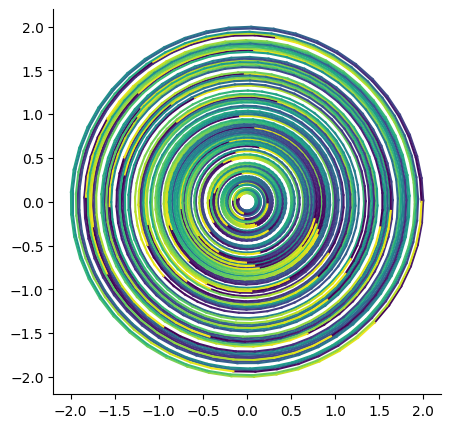

In [3]:
seed = 41
key = random.PRNGKey(seed)
key1, key2, key3 = random.split(key, 3)

K = 100
T = 50
split = 20
N = 2
d = 2 

X = get_rotations(K, T, key1)
#X = add_low_rank_noise(X, key2, key3)
#X = center(X)

X_train=X[split:]
X_test=X[:split]
K, N, T = X_train.shape
A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)


plot_2D(X_train)

print(np.mean(compute_S(X_train)))
print(compute_S_all_pairs(X_test))

In [19]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_train', X_train )
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_test', X_test )

Iteration 0, S: -0.00019908446120098233, S_ratio: -0.0006727931904606521
Iteration 10, S: 0.21179120242595673, S_ratio: 0.421614408493042
Iteration 20, S: 2.0653207302093506, S_ratio: 1.0040408372879028
Iteration 30, S: 7.694523334503174, S_ratio: 1.2394275665283203
Iteration 40, S: 17.21306800842285, S_ratio: 1.3109456300735474
Iteration 50, S: 35.169925689697266, S_ratio: 1.2254360914230347
Iteration 60, S: 50.088375091552734, S_ratio: 1.1485767364501953
Iteration 70, S: 50.98991012573242, S_ratio: 1.5672476291656494
Iteration 80, S: 53.93136215209961, S_ratio: 1.5415246486663818
Iteration 90, S: 61.58489990234375, S_ratio: 1.313025951385498
Iteration 100, S: 88.63121032714844, S_ratio: 1.253188967704773
Iteration 110, S: 82.70613861083984, S_ratio: 1.340606451034546
Iteration 120, S: 92.323486328125, S_ratio: 1.4307807683944702
Iteration 130, S: 93.48772430419922, S_ratio: 1.1818329095840454
Iteration 140, S: 107.1522445678711, S_ratio: 1.2232154607772827
Iteration 150, S: 98.785079

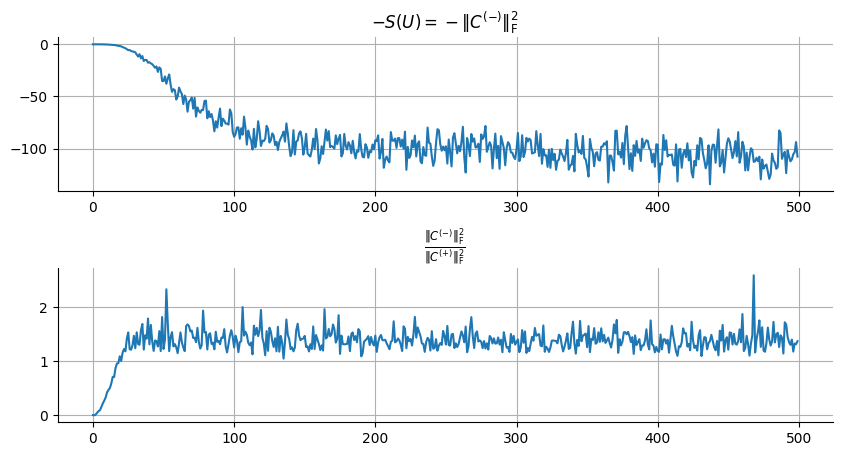

In [5]:
kernel_function=K_X_Y_rational_quadratic
c = 30
d = 2

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=500, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )




1.5071116e-05


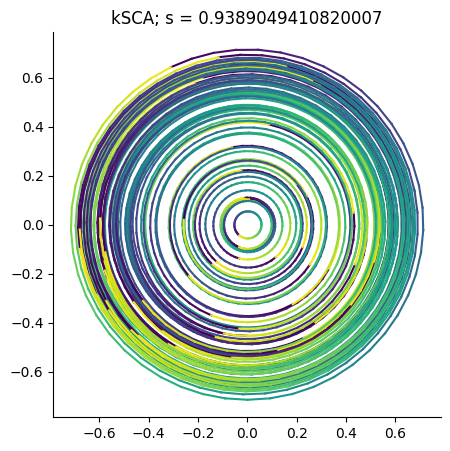

In [6]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u  = get_alpha(params, A, X_train, kernel_function, d)

K_test, _, _ = X_test.shape
X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

def var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u):
    return  np.trace( K_u_u_K_u_A_alpha_H.T @ K_u_u_K_u_A_alpha_H / np.trace(K_A_u @ K_u_u @ K_A_u.T )   ) #

print(var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u))

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/Y_train', Y)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_loss', np.array(ls_loss))
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_S_ratio', np.array(ls_S_ratio))

Iteration 0, S: 9756.3017578125, S_ratio: 0.3147284984588623
Iteration 10, S: 9452.7822265625, S_ratio: 0.31342729926109314
Iteration 20, S: 9706.5859375, S_ratio: 0.3169569969177246
Iteration 30, S: 9828.87109375, S_ratio: 0.3147127330303192
Iteration 40, S: 9474.5234375, S_ratio: 0.31495559215545654
Iteration 50, S: 9600.02734375, S_ratio: 0.31515243649482727
Iteration 60, S: 9658.8154296875, S_ratio: 0.31322041153907776
Iteration 70, S: 9449.40234375, S_ratio: 0.3155577480792999
Iteration 80, S: 9684.2783203125, S_ratio: 0.3143575191497803
Iteration 90, S: 9665.451171875, S_ratio: 0.31401002407073975
Iteration 100, S: 9670.3291015625, S_ratio: 0.3174731731414795
Iteration 110, S: 9582.9697265625, S_ratio: 0.3171654939651489
Iteration 120, S: 9651.587890625, S_ratio: 0.3125600516796112
Iteration 130, S: 9565.7255859375, S_ratio: 0.31664374470710754
Iteration 140, S: 9592.232421875, S_ratio: 0.31287404894828796
Iteration 150, S: 9550.439453125, S_ratio: 0.315518856048584
Iteration 160

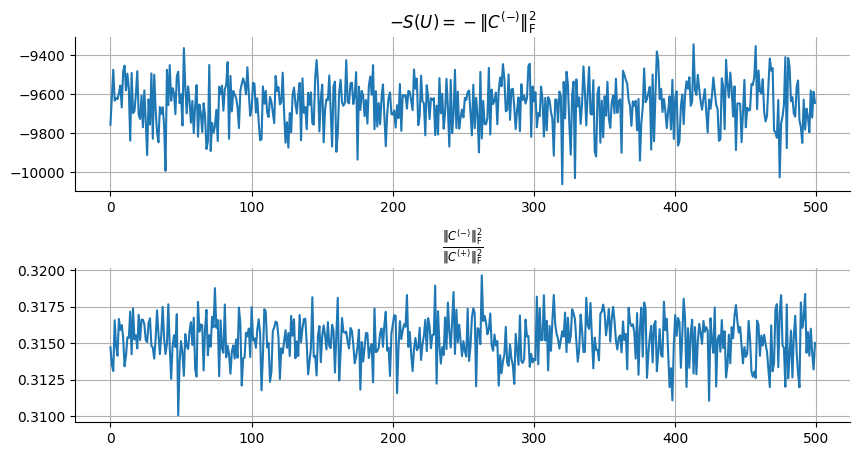

In [32]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X_train, d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


Text(0.5, 1.0, 'SCA; s = 0.3148902654647827')

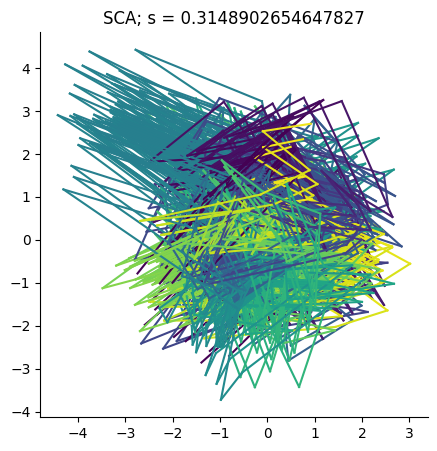

In [33]:

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X_train)
plot_2D(Y)
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/Y_test', Y)
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_loss', np.array(ls_loss))
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_S_ratio', np.array(ls_S_ratio))

Text(0.5, 1.0, 'pca 1.00')

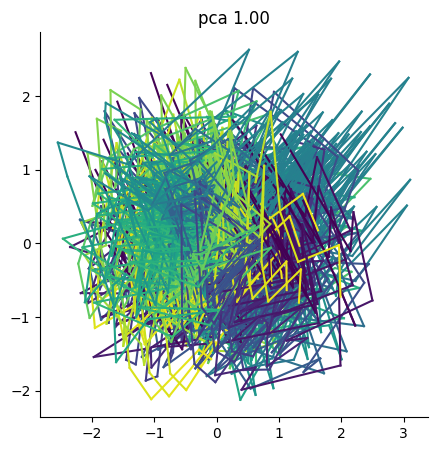

In [71]:
""" PCA """
X_pca_train = X_train.swapaxes(1,2).reshape(-1, N)
X_pca_test = X_test.swapaxes(1,2).reshape(-1, N)

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
#plt.title(f"pca {var_explained(X, PCs[:2].T):.2f}")
plt.title(f'PCA; s = {compute_S_all_pairs(Y_pca)}')

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/pca/Y_train', Y_pca)

In [54]:
compute_S_all_pairs(jnp.array(Y_pca))

Array(-0.01114135, dtype=float32)